<ipython-input-1-a4ab3198e109>:111: RuntimeWarning: divide by zero encountered in log
  log_thc = data.apply(lambda x: np.log(calculate_total_thc(x)), axis=1)
<ipython-input-1-a4ab3198e109>:112: RuntimeWarning: divide by zero encountered in log
  log_cbd = data.apply(lambda x: np.log(calculate_total_cbd(x)), axis=1)
<ipython-input-1-a4ab3198e109>:103: RuntimeWarning: divide by zero encountered in log
  log_cbd = np.log(calculate_total_cbd(row))
<ipython-input-1-a4ab3198e109>:102: RuntimeWarning: divide by zero encountered in log
  log_thc = np.log(calculate_total_thc(row))
<ipython-input-1-a4ab3198e109>:105: RuntimeWarning: invalid value encountered in double_scalars
  return log_thc - log_cbd


Proportion of data with known strains: 0.05


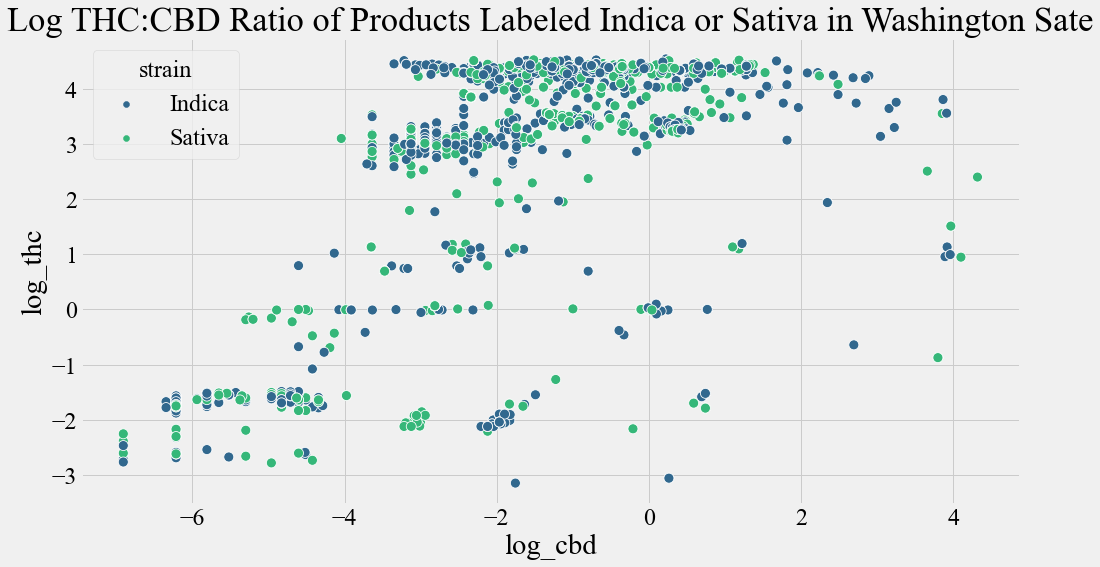

         Current function value: 0.373067
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:                 Indica   No. Observations:                 2350
Model:                         Probit   Df Residuals:                     2347
Method:                           MLE   Df Model:                            2
Date:                Sat, 26 Mar 2022   Pseudo R-squ.:                     inf
Time:                        20:26:40   Log-Likelihood:                -876.71
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
kush            7.4786   7.63e+04    9.8e-05      1.000    -1.5e+05     1.5e+05
purple         32.6123  1.81e+114   1.8e-113      1.000  -3.56

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Anaconda\lib\site-packages\statsmodels\discrete\discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


Predicted Indica of unknown strains: 0.69
Estimated percent of Indica products: 0.66


In [1]:
"""
Probit Models to Predict Cannabis Strains
Copyright (c) 2022 Cannlytics

Authors: Keegan Skeate <keegan@cannlytics.com>
Created: 3/26/2022
Updated: 3/26/2022
License: MIT License <https://opensource.org/licenses/MIT>

Data sources:

    - WA State Traceability Data January 2018 - November 2021
    https://lcb.app.box.com/s/e89t59s0yb558tjoncjsid710oirqbgd

    - Random Sample of WA Sales Items from 2022-03-16
    https://cannlytics.page.link/cds57

"""
# External imports.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Define the plot style.
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 24})


#--------------------------------------------------------------------------
# Read the sample sales data.
# Random sample of sales: https://cannlytics.page.link/cds57
#--------------------------------------------------------------------------

# Read in the data from where your data lives.
DATA_DIR = '../.datasets'
DATA_FILE = f'{DATA_DIR}/random-sales-items-2022-03-16.csv'
data = pd.read_csv(DATA_FILE, low_memory=False, parse_dates=['date'], index_col=0)

# Restrict the time period.
data = data.loc[
    (data['date'] >= pd.to_datetime('2020-01-01')) &
    (data['date'] < pd.to_datetime('2021-11-01'))
]

# Remove sale outliers.
data = data.loc[data['price_total'] >= 0.25]


#--------------------------------------------------------------------------
# Add explanatory variables.
#--------------------------------------------------------------------------

# Add Kush identifier.
kush = data['product_name'].apply(
    lambda x: 1 if 'kush' in x.lower() else 0
)
data = data.assign(kush=kush)


# Add Northern Lights identifier.
lights = data['product_name'].apply(
    lambda x: 1 if 'northern lights' in x.lower() else 0
)
data = data.assign(northern_lights=lights)


# Add a purple identifier.
purple = data['product_name'].apply(
    lambda x: 1 if 'purple' in x.lower() else 0
)
data = data.assign(purple=purple)


def calculate_total_thc(row):
    """Calculate the total THC for a given observation.
    Source for decarboxylated value conversion factor:
    https://www.conflabs.com/why-0-877/
    """
    try:
        thca = row.loc['cannabinoid_d9_thca_percent'] * 0.877
    except TypeError:
        thca = 0
    return row.loc['cannabinoid_d9_thc_percent'] + thca


def calculate_total_cbd(row):
    """Calculate the total THC for a given observation.
    Source for decarboxylated value conversion factor:
    https://www.conflabs.com/why-0-877/
    """
    try:
        thca = row.loc['cannabinoid_cbda_percent'] * 0.877
    except TypeError:
        thca = 0
    return row.loc['cannabinoid_cbd_percent'] + thca


def calculate_log_thc_cbd(row):
    """Calculate the log THC:CBD ratio of an observation."""
    log_thc = np.log(calculate_total_thc(row))
    log_cbd = np.log(calculate_total_cbd(row))
    try:
        return log_thc - log_cbd
    except:
        return 0


# Calculate log THC:CBD ratio.
log_thc = data.apply(lambda x: np.log(calculate_total_thc(x)), axis=1)
log_cbd = data.apply(lambda x: np.log(calculate_total_cbd(x)), axis=1)
log_thc_cbd = data.apply(calculate_log_thc_cbd, axis=1)
data = data.assign(
    log_thc=log_thc,
    log_cbd=log_cbd,
    log_thc_cbd=log_thc_cbd
)


#--------------------------------------------------------------------------
# Classify observations as Indica or Sativa.
#--------------------------------------------------------------------------

def classify_strain(value):
    """Add an identifier, `strain`, to classify items as Indica or Sativa."""
    case = value.lower()
    if 'indica' in case:
        return 'Indica'
    elif 'sativa' in case:
        return 'Sativa'
    return pd.NA


# Add strain categorical variable.
data['strain'] = data['product_name'].apply(classify_strain)

# Identify the portion with "Indica" or "Sativa" in the product name.
strain_data = data.loc[~data['strain'].isna()]
known_strains = round(len(strain_data) / len(data), 2)
print('Proportion of data with known strains:', known_strains)


#--------------------------------------------------------------------------
# Visualize the data.
#--------------------------------------------------------------------------

# "Log-log plot makes it easy to see the pattern of variation as well as
# unusually high values." (Tidy Data, Hadley Wickham 2014)
subsample = strain_data.loc[
    (~strain_data['log_thc'].isnull()) &
    (~np.isinf(strain_data['log_thc'])) &
    (~np.isinf(strain_data['log_cbd'])) &
    (~strain_data['log_cbd'].isnull())
]
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(
    data=subsample,
    x='log_cbd',
    y='log_thc',
    hue='strain',
    palette=sns.color_palette('viridis', n_colors=2),
    s=100,
    ax=ax,
)
plt.title('Log THC:CBD Ratio of Products Labeled Indica or Sativa in Washington Sate')
plt.show()


#--------------------------------------------------------------------------
# Build a model to predict strain given a readily available factors:
# ✓ Kush naming
# ✓ Purple naming
# ✓ log THC:CBD ratio
# - Add your own factors to build a better model!
#--------------------------------------------------------------------------

# Define the explanatory variables.
explanatory_variables = [
    'kush',
    'purple',
    'log_thc_cbd' # Including predicts Indica better, excluding predicts Sativa better!
]

# Fit a probit model (letting Indica be 1 and Sativa 0).
Y = pd.get_dummies(subsample['strain'])['Indica']
X = subsample[explanatory_variables]
model = sm.Probit(Y, X).fit()
print(model.summary())

# Make predictions for the sample
sample_predictions = model.predict(X)

# See how well the model predicts the sample.
subsample = subsample.assign(predicted_indica=0)
subsample.loc[sample_predictions > 0.5, 'predicted_indica'] = 1

# Percent of predicted Indica that are actually Indica.
indica_correct = subsample.loc[
    (subsample['strain'] == 'Indica') &
    (subsample['predicted_indica'] == 1)
]
matched = round(len(indica_correct) / len(subsample), 2)
print('Indica matched correctly in sample:', matched)

# Percent of predicted Sativa that are actually Sativa.
sativa_correct = subsample.loc[
    (subsample['strain'] == 'Sativa') &
    (subsample['predicted_indica'] == 0)
]
matched = round(len(sativa_correct) / len(subsample), 2)
print('Sativa matched correctly in sample:', matched)


#--------------------------------------------------------------------------
# Use the model to predict the strain for the rest of the data.
#--------------------------------------------------------------------------

# Predict unknown strains.
unidentified_data = data[~data.index.isin(strain_data.index)]
predicted_strains = model.predict(unidentified_data[explanatory_variables])
predicted_indica = unidentified_data.loc[predicted_strains > 0.5]
percent_unknown_indica = round(len(predicted_indica) / len(unidentified_data), 2)
print('Predicted Indica of unknown strains:', percent_unknown_indica)

# Aggregate with known strain data.
data = data.assign(predicted_strain='Unknown')
data.loc[data.index.isin(predicted_indica.index), 'predicted_strain'] = 'Indica'
data.loc[~data.index.isin(predicted_indica.index), 'predicted_strain'] = 'Sativa'
data.loc[data.index.isin(strain_data.index), 'predicted_strain'] = strain_data['strain']
estimated_percent_indica = round(len(predicted_indica) / len(data), 2)
print('Estimated percent of Indica products:', estimated_percent_indica)

# Wahoo! We have now augmented the data with strain data by imputing
# missing values! Keep up the good work :)